In [1]:
from datetime import datetime

import numpy as np
import torch
from gym.wrappers import (
    FilterObservation,
    FlattenObservation,
    FrameStack,
    RecordVideo,
    RescaleAction,
    TimeLimit,
)
from stable_baselines3.common.env_util import unwrap_wrapper

from bayesopt import calculate_objective, get_next_samples, scale_action
from ea_optimize import (
    ARESEADOOCS,
    CallbackList,
    OptimizeFunctionCallback,
    report_ea_optimization_to_logbook,
)
from utils import (
    FilterAction,
    NotVecNormalize,
    PolishedDonkeyCompatibility,
    RecordEpisode,
    send_to_elog,
)


initializing ocelot...


## Preamble

Remarks: I would set a higher max_step for BO, maybe 100/150?

In [2]:
config = config = {
    "action_mode": "direct_unidirectional_quads",
    "gamma": 0.99,
    # "filter_action": [0, 1, 3],
    "filter_action": None,
    "filter_observation": None,
    "frame_stack": None,
    "incoming_mode": "random",
    "incoming_values": None,
    "magnet_init_mode": "constant",
    "magnet_init_values": np.array([10, -10, 0, 10, 0]),
    "misalignment_mode": "constant",
    "misalignment_values": np.zeros(8),
    "n_envs": 40,
    "normalize_observation": True,
    "normalize_reward": True,
    "rescale_action": (-3, 3),
    "reward_mode": "logl1",
    "sb3_device": "auto",
    "target_beam_mode": "constant",
    "target_beam_values": np.zeros(4),
    "target_mu_x_threshold": 1e-5,
    "target_mu_y_threshold": 1e-5,
    "target_sigma_x_threshold": 1e-5,
    "target_sigma_y_threshold": 1e-5,
    "threshold_hold": 5,
    "time_limit": 50000,
    "vec_env": "subproc",
    "w_done": 0.0,
    "w_mu_x": 1.0,
    "w_mu_x_in_threshold": 0.0,
    "w_mu_y": 1.0,
    "w_mu_y_in_threshold": 0.0,
    "w_on_screen": 0.0,
    "w_sigma_x": 1.0,
    "w_sigma_x_in_threshold": 0.0,
    "w_sigma_y": 1.0,
    "w_sigma_y_in_threshold": 0.0,
    "w_time": 0.0,
}


In [3]:
# define a similar optimize function as in ea_optimize.py
def optimize(
    target_mu_x,
    target_sigma_x,
    target_mu_y,
    target_sigma_y,
    target_mu_x_threshold=3.3198e-6,
    target_mu_y_threshold=3.3198e-6,
    target_sigma_x_threshold=3.3198e-6,
    target_sigma_y_threshold=3.3198e-6,
    max_steps=100,
    model_name="BO",
    logbook=False,
    callback=None,
    obj_function="logmae",
    acquisition="EI",
    init_x=None,
    init_samples=5,
    filter_action=None,
):
    callback = CallbackList(callback) if isinstance(callback, list) else callback

    # Create the environment
    env = ARESEADOOCS(
        action_mode=config["action_mode"],
        magnet_init_mode=config["magnet_init_mode"],
        magnet_init_values=config["magnet_init_values"],
        reward_mode=config["reward_mode"],
        target_beam_mode=config["target_beam_mode"],
        target_beam_values=np.array(
            [target_mu_x, target_sigma_x, target_mu_y, target_sigma_y]
        ),
        target_mu_x_threshold=target_mu_x_threshold,
        target_mu_y_threshold=target_mu_y_threshold,
        target_sigma_x_threshold=target_sigma_x_threshold,
        target_sigma_y_threshold=target_sigma_y_threshold,
        threshold_hold=1,
        w_done=config["w_done"],
        w_mu_x=config["w_mu_x"],
        w_mu_x_in_threshold=config["w_mu_x_in_threshold"],
        w_mu_y=config["w_mu_y"],
        w_mu_y_in_threshold=config["w_mu_y_in_threshold"],
        w_on_screen=config["w_on_screen"],
        w_sigma_x=config["w_sigma_x"],
        w_sigma_x_in_threshold=config["w_sigma_x_in_threshold"],
        w_sigma_y=config["w_sigma_y"],
        w_sigma_y_in_threshold=config["w_sigma_y_in_threshold"],
        w_time=config["w_time"],
    )
    if max_steps is not None:
        env = TimeLimit(env, max_steps)
    if callback is not None:
        env = OptimizeFunctionCallback(env, callback)
    env = RecordEpisode(env)
    if config["filter_observation"] is not None:
        env = FilterObservation(env, config["filter_observation"])
    if config["filter_action"] is not None:
        env = FilterAction(env, config["filter_action"], replace=0)
    env = FlattenObservation(env)
    if config["frame_stack"] is not None:
        env = FrameStack(env, config["frame_stack"])
    if config["rescale_action"] is not None:
        env = RescaleAction(
            env, config["rescale_action"][0], config["rescale_action"][1]
        )
    env = RecordVideo(env, video_folder=f"recordings_real/{datetime.now():%Y%m%d%H%M}")
    # env = NotVecNormalize(env, f"models/{model_name}/vec_normalize.pkl")

    callback.env = env

    # Actual optimisation
    t_start = datetime.now()
    observation = env.reset()
    beam_image_before = env.get_beam_image()
    done = False

    # Initialization
    x_dim = env.action_space.shape[0]
    bounds = torch.tensor(
        np.array([env.action_space.low, env.action_space.high]), dtype=torch.float32
    )
    if init_x is not None:  # From fix starting points
        X = torch.tensor(init_x.reshape(-1, x_dim), dtype=torch.float32)
    else:  # Random Initialization-5.7934
        action_i = scale_action(env, observation, filter_action)
        X = torch.tensor([action_i], dtype=torch.float32)
        for i in range(init_samples - 1):
            X = torch.cat([X, torch.tensor([env.action_space.sample()])])
    # Sample initial Ys to build GP
    Y = torch.empty((X.shape[0], 1))
    for i, action in enumerate(X):
        action = action.detach().numpy()
        print(f"Collecting initial Ys step {i} at {action = }")
        observation, reward, done, info = env.step(action)
        objective = calculate_objective(env, observation, reward, obj=obj_function)
        Y[i] = torch.tensor(objective)

    # Actual BO Loop
    jans_i = 0
    while not done:
        # action, _ = model.predict(observation, deterministic=True)
        action_t = get_next_samples(
            X, Y, Y.max(), bounds, n_points=1, acquisition=acquisition
        )
        action = action_t.detach().numpy().flatten()
        print(f"Actual optimisation exploring step {jans_i} {action = }")
        jans_i += 1
        observation, reward, done, info = env.step(action)
        objective = calculate_objective(env, observation, reward, obj=obj_function)

        # append data
        X = torch.cat([X, action_t])
        Y = torch.cat([Y, torch.tensor([[objective]], dtype=torch.float32)])

    t_end = datetime.now()

    recording = unwrap_wrapper(env, RecordEpisode)
    if logbook:
        report_ea_optimization_to_logbook(
            model_name,
            t_start,
            t_end,
            recording.observations,
            recording.infos,
            beam_image_before,
            target_mu_x_threshold,
            target_sigma_x_threshold,
            target_mu_y_threshold,
            target_sigma_y_threshold,
        )

    env.close()


## Actual BO

/tmp/ipykernel_2943224/3954147879.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  X = torch.cat([X, torch.tensor([env.action_space.sample()])])


      dtype=float32)
      dtype=float32)
      dtype=float32)
      dtype=float32)
      dtype=float32)
Actual optimisation exploring step 0 action = array([ 0.6159775, -0.8341718, -0.9456401, -2.32467  ,  2.0891495],
      dtype=float32)
Actual optimisation exploring step 1 action = array([-2.6521885, -2.6957052, -2.8265345, -1.1099635, -2.1535568],
      dtype=float32)
Actual optimisation exploring step 2 action = array([ 2.4553719, -0.9675553,  0.6977067,  2.866527 ,  2.5372329],
      dtype=float32)
Actual optimisation exploring step 3 action = array([ 0.08668399,  0.90049267, -1.2696977 ,  2.070343  ,  1.0692186 ],
      dtype=float32)
Actual optimisation exploring step 4 action = array([ 1.4547825,  2.7101316, -1.4034323, -1.7260363, -2.689456 ],
      dtype=float32)
Actual optimisation exploring step 5 action = array([-2.3819542 , -0.9891355 ,  0.61040497,  1.0182819 ,  2.336824  ],
      dtype=float32)
Actual optimisation exploring step 6 action = array([-0.52520204, -1.524938

/home/kaiserja/.conda/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/kaiserja/.conda/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 74 action = array([-0.74479485,  0.59882605,  1.128747  ,  0.99690545,  0.17487997],
      dtype=float32)
Actual optimisation exploring step 75 action = array([-1.1566619 ,  0.03824997, -0.95514584, -0.32915688, -0.87558365],
      dtype=float32)
Actual optimisation exploring step 76 action = array([-1.7168024 ,  0.49256104, -0.23126887,  0.08141378, -0.6778382 ],
      dtype=float32)
Actual optimisation exploring step 77 action = array([-0.9923358 ,  0.47029424,  0.8299031 , -0.7342503 ,  0.8373575 ],
      dtype=float32)
Actual optimisation exploring step 78 action = array([-1.4199994 ,  0.57573944, -0.06056072,  0.2532869 , -0.3654691 ],
      dtype=float32)
Actual optimisation exploring step 79 action = array([-0.9345316 ,  0.62862486,  0.18228526,  0.22719245, -0.09381352],
      dtype=float32)
Actual optimisation exploring step 80 action = array([ 0.9371071 , -0.00370097,  0.29949403, -1.0099127 ,  1.4747696 ],
      dtype=float32)
Actual optimi

/home/kaiserja/.conda/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Actual optimisation exploring step 84 action = array([-2.8979008 ,  1.8030906 ,  0.72272825,  0.14072227, -1.2707455 ],
      dtype=float32)
Actual optimisation exploring step 85 action = array([-2.7355485 ,  1.5301003 ,  0.8906572 , -0.1910572 ,  0.39626384],
      dtype=float32)
Actual optimisation exploring step 86 action = array([-2.8622708 ,  1.719585  , -0.13635445, -0.08910418, -1.8664263 ],
      dtype=float32)
Actual optimisation exploring step 87 action = array([-1.0607789,  1.0890222,  0.7621112, -2.7405844,  1.6898112],
      dtype=float32)
Actual optimisation exploring step 88 action = array([-0.2672801 ,  0.67177176,  0.38214186,  0.07022122,  0.14863399],
      dtype=float32)
Actual optimisation exploring step 89 action = array([ 0.13956384,  0.5533683 ,  0.21547484, -0.7578857 ,  0.10269708],
      dtype=float32)
Actual optimisation exploring step 90 action = array([-1.4505998 ,  0.60048777, -0.14141043,  0.10554312, -0.50729376],
      dtype=float32)
Actual optimisatio

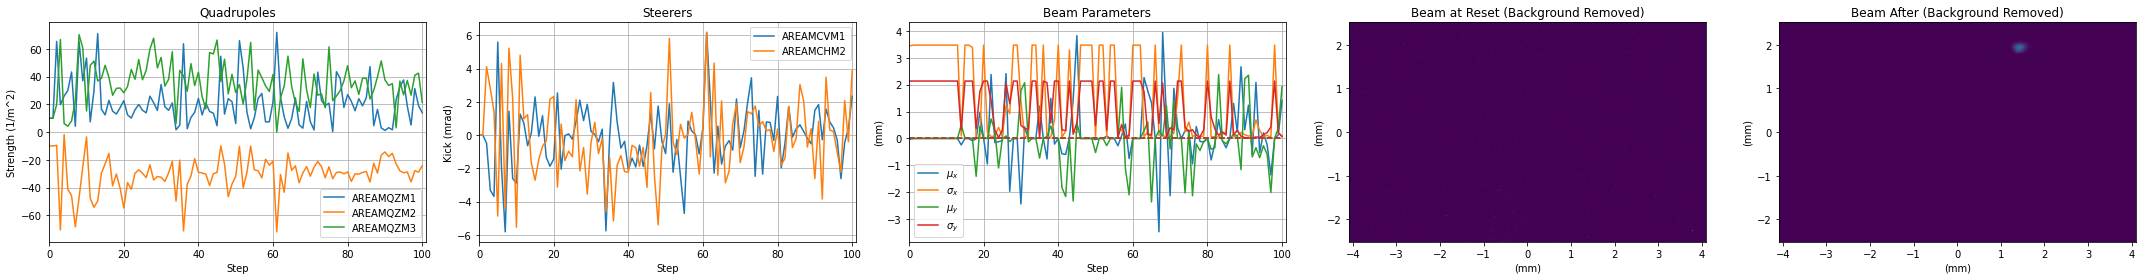

In [4]:
# hopefully this would run :)

optimize(
    target_mu_x=0.0,    # 0.4249e-3,
    target_sigma_x=0.0,
    target_mu_y=0.0,    # 1.1048e-3,
    target_sigma_y=0.0,
    target_mu_x_threshold=3.16e-6,
    target_mu_y_threshold=3.16e-6,
    target_sigma_x_threshold=3.16e-6,
    target_sigma_y_threshold=3.16e-6,
    max_steps=100,
    model_name="BO",
    logbook=True,
    callback=None,
    obj_function="logmae",
    acquisition="EI",
    init_x=None,
    init_samples=5,
    filter_action=None,
)
